# Comparison of different explainers
## CORA - multiclass classification, GCN network

In [1]:
import torch
from torch.nn import Dropout, ReLU, LogSoftmax
from torch.nn.functional import nll_loss
from torch_geometric.nn import Sequential, GCNConv
from torch_geometric.datasets import Planetoid

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = Planetoid(root="./data/cora", name="cora")
data = dataset[0].to(device)

model = Sequential("x, edge_index", [
    (GCNConv(dataset.num_features, 16), "x, edge_index -> x"),
    ReLU(inplace=True),
    Dropout(0.5),
    (GCNConv(16, dataset.num_classes), "x, edge_index -> x"),
    LogSoftmax(dim=1)
]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for _ in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

model.eval()
pred = model(data.x, data.edge_index).argmax(dim=1)
acc_train = (pred[data.train_mask] == data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()
acc_test = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
print(f'Training acc: {acc_train:.2f}, test acc: {acc_test:.2f}')

Training acc: 1.00, test acc: 0.80


In [2]:
from torch_geometric.explain import Explainer, GNNExplainer, PGExplainer, GraphMaskExplainer, metric
from fidelity import fidelity
import numpy as np
import copy

# Gather explanations for random 50 nodes
n_idxs = 50
n_runs = 5
nodes_idxs = torch.randperm(data.num_nodes)[:n_idxs]
topk = [5, 10, 15, 20, 50, 100]

explainer_names = ['GNNExplainer', 'PGExplainer', 'GraphMaskExplainer']
metric_names = ['Fidelity+', 'Fidelity-', 'Fidelity AUC', 'Characterization score', 'Unfaithfulness']
results = []
model_ = model

for _ in range(n_runs):
    run_results = {e: {m: [] for m in metric_names } for e in explainer_names}
    for i in range(len(topk)):

        topk_val = topk[i]
        model = copy.deepcopy(model_)
        fid = {'+': np.zeros(n_idxs), '-': np.zeros(n_idxs)}
        fls = np.zeros(n_idxs)

        # GNNExplainer
        gnn_exp = Explainer(
            model=model,
            algorithm=GNNExplainer(epochs=200),
            explanation_type='phenomenon',
            edge_mask_type='object',
            model_config=dict(
                mode='multiclass_classification',
                task_level='node',
                return_type='log_probs',
            ),
            threshold_config=dict(threshold_type='topk', value=topk_val),
        )

        # PGExplainer
        pg_exp = Explainer(
            model=model,
            algorithm=PGExplainer(epochs=1, lr=0.001).to(device),
            explanation_type='phenomenon',
            edge_mask_type='object',
            model_config=dict(
                mode='multiclass_classification',
                task_level='node',
                return_type='raw',
            ),
            threshold_config=dict(threshold_type='topk', value=topk_val),
        )

        for epoch in range(1):
            for index in range(data.num_nodes):
                pg_exp.algorithm.train(epoch, model, data.x, data.edge_index, target=data.y, index=index)

        # GraphMaskExplainer
        gm_exp = Explainer(
            model=model,
            algorithm=GraphMaskExplainer(2, epochs=10),
            explanation_type='phenomenon',
            edge_mask_type='object',
            model_config=dict(
                mode='multiclass_classification',
                task_level='node',
                return_type='log_probs',
            ),
            threshold_config=dict(threshold_type='topk', value=topk_val),
        )

        explainers = { 'GNNExplainer': gnn_exp, 'PGExplainer': pg_exp, 'GraphMaskExplainer': gm_exp}
        for name, explainer in explainers.items():
            for j in range(n_idxs):
                node_index = nodes_idxs[j].item()
                explanation = explainer(data.x, data.edge_index, index=node_index, target=data.y)
                fid['+'][j], fid['-'][j] = fidelity(explainer, explanation)
                fls[j] = metric.unfaithfulness(explainer, explanation)

            run_results[name]['Fidelity+'].append(fid['+'].mean())
            run_results[name]['Fidelity-'].append(fid['-'].mean())
            # Replace 0 with 0.001 in fidelity+ to avoid division by zero
            fid['+'][fid['+'] == 0] = 0.001
            # Replace 1 with 0.999 in fidelity- to avoid division by zero
            fid['-'][fid['-'] == 1] = 0.999
            run_results[name]['Fidelity AUC'].append(metric.fidelity_curve_auc(torch.tensor(fid['+']), torch.tensor(fid['-']), torch.arange(0, n_idxs)).item())
            run_results[name]['Characterization score'].append(metric.characterization_score(fid['+'].mean(), fid['-'].mean(), pos_weight=0.5, neg_weight=0.5))
            run_results[name]['Unfaithfulness'].append(fls.mean())
    results.append(run_results)


Train explainer for node(s) tensor([1680]) with layer 1: 100%|██████████| 10/10 [00:00<00:00, 20.30it/s]
Train explainer for node(s) tensor([1680]) with layer 0: 100%|██████████| 10/10 [00:00<00:00, 71.46it/s]
Explain: 100%|██████████| 2/2 [00:00<00:00, 500.04it/s]
Train explainer for node(s) tensor([709]) with layer 1: 100%|██████████| 10/10 [00:00<00:00, 115.89it/s]
Train explainer for node(s) tensor([709]) with layer 0: 100%|██████████| 10/10 [00:00<00:00, 96.51it/s]
Explain: 100%|██████████| 2/2 [00:00<00:00, 666.66it/s]
Train explainer for node(s) tensor([2306]) with layer 1: 100%|██████████| 10/10 [00:00<00:00, 119.64it/s]
Train explainer for node(s) tensor([2306]) with layer 0: 100%|██████████| 10/10 [00:00<00:00, 96.99it/s]
Explain: 100%|██████████| 2/2 [00:00<00:00, 569.03it/s]
Train explainer for node(s) tensor([1534]) with layer 1: 100%|██████████| 10/10 [00:00<00:00, 117.03it/s]
Train explainer for node(s) tensor([1534]) with layer 0: 100%|██████████| 10/10 [00:00<00:00, 90

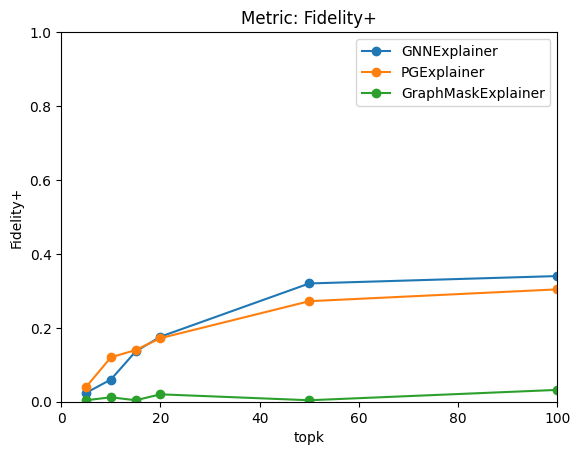

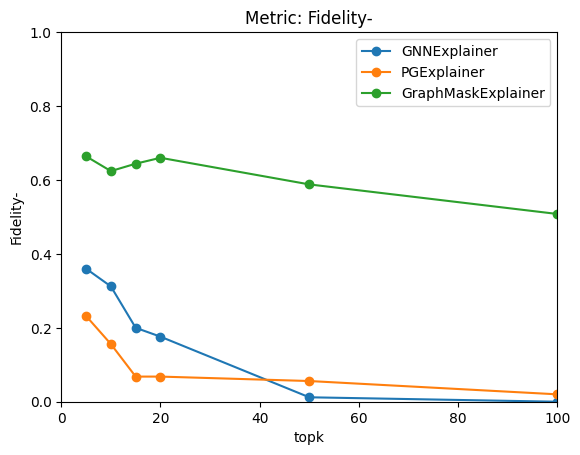

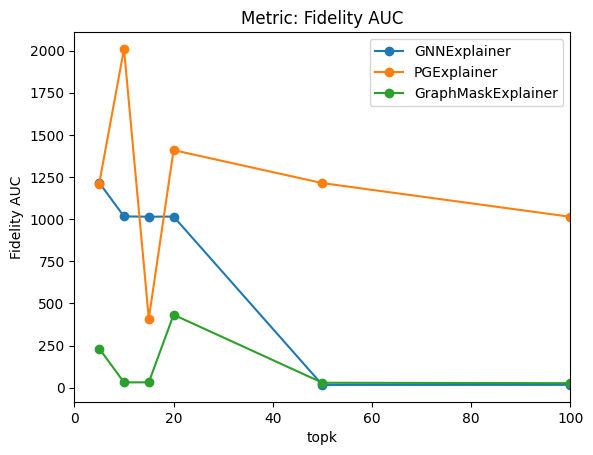

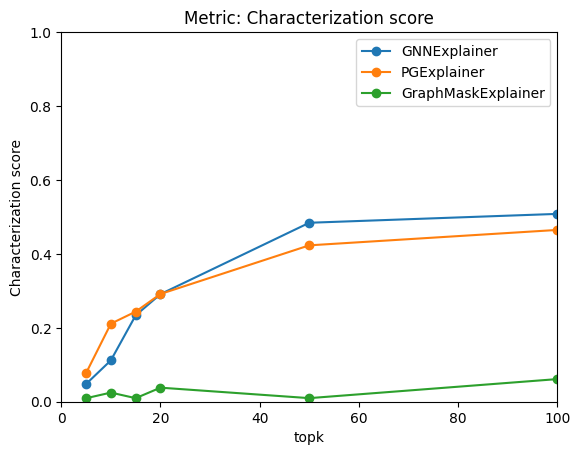

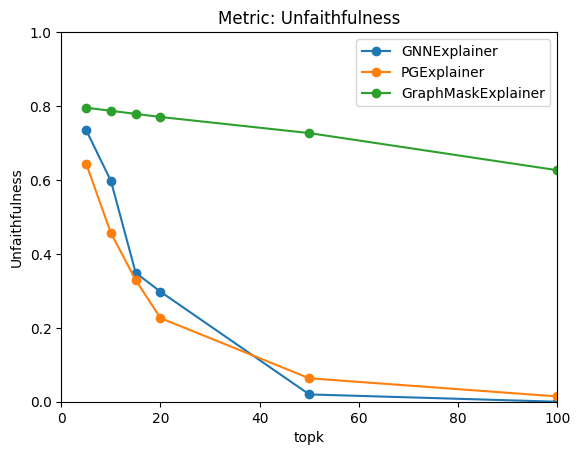

In [10]:
import matplotlib.pyplot as plt

agg_results = {e: {m: [0] * len(topk) for m in metric_names } for e in explainer_names}

for r in results:
    for e in explainer_names:
        for m in metric_names:
            for i in range(len(topk)):
                agg_results[e][m][i] += r[e][m][i] / n_runs

for m in metric_names:
    plt.figure()
    for e in explainer_names:
        plt.plot(topk, agg_results[e][m], marker='o', label=e)
    if m != 'Fidelity AUC':
        plt.ylim(0, 1)
    plt.xlim(0, 100)
    plt.ylabel(m)
    plt.xlabel('topk')
    plt.legend()
    plt.title(f'Metric: {m}')
    plt.show()
